# Detecting calcium signaling waves in timelapse movies
This notebook demonstrates the workflow for detecting calcium signalling waves in microscopy images using [ARCOS](https://doi.org/10.1083/jcb.202207048), a tool to detect spatio-temporal signaling patterns.
The data was originally acquired by [Takeuchi Y. et al. (2023)](https://doi.org/10.1016/j.cub.2019.11.089) and is available from the bioimage archive under accession nymber [S-BIAD1135](https://doi.org/10.6019/S-BIAD1135).

The main steps are to segment the cells with convpaint, then process the labels to get a ring-like mask for every cell:

<img src="../images/calcium_waves_workflow/workflow_segmentation.png" style="width:600px;"/>

Then we use ARCOS for automatically detecting collective signalling events:

<img src="../images/calcium_waves_workflow/workflow_arcos.png" style="width:600px;"/>

Here is a movie of the output of this script. Active cells are marked with a black dot. Collective events are outlined in color, and cells that are active and belong to the collective event are marked with a colored dot. 

<div style="text-align: left;">
    <video controls src="../images/calcium_waves_workflow/arcos_output.mp4" style="width:500px;"/>
</div>

Before we start, make sure you have the following python packages installed:
- [`convpaint`](https://github.com/guiwitz/napari-convpaint) for segmenting the cells from the background
- [`devbio-napari`](https://github.com/haesleinhuepf/devbio-napari) large collection of napari plugins for bioimage analysis (we mostly need napari-assistant for post-processing the labels)
- [`btrack`](https://btrack.readthedocs.io/en/latest/user_guide/napari.html) to track cells over time
- [`arcos-gui`](https://github.com/bgraedel/arcos-gui) to detect collective event

# Download the data, drag-and-drop it to open in Napari
Download the file `calcium_waves.tif` and unzip.

![](../images/calcium_waves_workflow/download_data.png)


<div class="alert alert-block alert-info">
<b>Tip:</b> In the bioimage archive we also provide intermediate outputs of this script as reference. If you want to reproduce our exact results, you can also download the files in the section `Reference Data Analysis of Calcium wave in MDCK epithelium` and move them to the folder `../sample_datacalcium_waves_workflow`.
</div>


Next, open napari:


In [ ]:
import napari
import numpy as np

viewer = napari.Viewer()

# Segment the cells using conv-paint
Drag-and-drop the .tif file to open it in napari.

![](../images/calcium_waves_workflow/open_in_napari.png)

Open the Convpaint plugin and start adding annotations. To reproduce our results, you can also load the `annotations.npz` file.

![](../images/calcium_waves_workflow/annotate.png)

In [36]:
# save your own annotations:
# np.savez_compressed('../sample_data/calcium_waves_workflow/annotations.npz', a=annotations)

# load pre-made annotations (frame 53 is annotated)
annotations = np.load('../sample_data/calcium_waves_workflow/annotations.npz')['a']
viewer.add_labels(annotations, name='annotations')

### Train the classifier, check segmentation results, segment whole stack
For this workflow, using VGG16 single-layer and input scalings 1-2-4 works well.

If you are happy with the segmentation results, click `Segment stack`.

![](../images/calcium_waves_workflow/segment_stack.png)


You can store/load segmentation results with the following code or using the napari GUI.

In [38]:
# save your segmentation results
# segmentation = viewer.layers['segmentation'].data
# np.savez_compressed('../sample_data/calcium_waves_workflow/segmentation.npz', a=segmentation)

# load previous segmentation results
segmentation = np.load('../sample_data/calcium_waves_workflow/segmentation.npz')['a']
viewer.add_labels(segmentation, name='segmentation')


# Post-process the labels and detect collective signalling
Use the `napari-assistant` plugin for:

0. Convert from 3D to 2D+t format
1. Voronoi-otsu labelling (convert semantic to instance segmentation)
2. Expand the labels
3. Only keep the edges of the labels, creating a labeled ring for all the cells
4. Convert to the right data format and save


After that we will:

5. use the `Btrack` napari plugin to track the cells
6. get the calcium activity of all the cells using `napari-skimage-regionprops`
7. Detect the collective events using `ARCOS`


### 0. Convert data format
Convert the data from `3D` to `2D timelapse` format, so that it conforms with napar-assistant convention. This also enables working with on-the-fly processing - only the currently viewed frame is being processed, enabling to quickly try out different parameters. More info can be found in the [napari-time-slicer](https://github.com/haesleinhuepf/napari-time-slicer) github repo. 

To do this, select `Utilities >> Convert 3D stack to 2D timelapse (time-slicer)`, select the data layer containing your segmentation, then click `Run`. Also convert the raw calcium imaging data. You can then delete the old layers.

### 1. Voronoi-Otsu labelling

From the menu choose: `Plugins >> clEsperanto >> Label`. You can test different Sigma values, but the default values work well here. 
<div class="alert alert-block alert-warning">
<b>Hint:</b> Be sure to select `2d + t segmentation` as your input layer. 
</div>

![](../images/calcium_waves_workflow/otsu.png)

### 2. Expand the labels

Open the napari-assistant, choose `Process labels`, then select 
`extend_labels_with_maximum_radius`. This will create a new labels layer where the original labels are expanded by 2 px.

![](../images/calcium_waves_workflow/expand.png)

### 3. Create cytosolic ring

3.1: From the napari-assistant, choose `Process labels`, then select 
`reduce_labels_to_labels_edges`.

3.2: Expand the edge-labels as again like we did in the step above (choose `Process labels`, then select 
`extend_labels_with_maximum_radius`)

![](../images/calcium_waves_workflow/edges.png)

![](../images/calcium_waves_workflow/edges_expanded.png)

### 4. Apply the processing to the whole stack
At the moment the processing is still applied lazily to the frames on the demand. In this step we actually run in on all the frames.

Select `Utilities >> Convert on-the-fly processesed timelapse to 4D stack (time-slicer)`. Select the layer with the latest processing and click `Run`.

You can rename the converted layer to e.g. `edges` and delete the layers with the intermediate processing steps. This is also a good timepoint to save the progress.

In [40]:
# save the processing results
# edges = viewer.layers['edges'].data
# np.savez_compressed('../sample_data/calcium_waves_workflow/edges.npz', a=edges)

# load the segmentation results
edges = np.load('../sample_data/calcium_waves_workflow/edges.npz')['a']
edges = np.squeeze(edges)
viewer.add_labels(edges, name='edges')

### 5. Get the calcium signal for each cell at each timepoint
Extract region properties for each frame using. Select `Measurements of all frames (n-SimpleITK)` from the menu, select the calcium data as image and the edges as labels (make sure both are in 2D+t format).

We need the `intensity` and `position` information, tick these then click on run.

<div class="alert alert-block alert-info">
<b>Tip:</b> As output you will get an interactive table. If you tick `show selected`, clicking on a line will highlight the cell in the viewer (in the screenshot the cell with the label 2101 in frame 222). You can save the data as CSV from the GUI. The data is also stored to the labels layer as a dict, where we can later retrieve it from.
</div>

![](../images/calcium_waves_workflow/properties.png)

### 6. Track the cells using the Btrack plugin

Next we link the edge-masks from frame to frame.
Change the parameters to 
- update method: `APPROXIMATE`
- search radius: `10` 
- max lost: `5`

![](../images/calcium_waves_workflow/btrack.png)

### 7. Detect collective events using ARCOS

Load the tracking data and cell properties from the track and labels layer respectively. Click `Load Data`, and add the appropriate columns. We need the centroids for matching the labels and track layers, as well as the measurement column (`mean` is the mean calcium signal extracted in step 5.) X/Y columns might be switched, depending on which plugin you use to extract the features. Click `Ok`.


![](../images/calcium_waves_workflow/arcos_import.png)


Next we run the `ARCOS` algorithm. Tick `Advanced Options`, select `runmed` as Bias Method, then click `Binarize Data`.

<div class="alert alert-block alert-warning">
<b>Attention:</b> Change Output Axis Order to `tzyx` if working with 2D+t transformed data (`tyx` otherwise).

</div>

Finally click `Update ARCOS` to run!

![](../images/calcium_waves_workflow/arcos_output.png)


### Plot ARCOS results

First we import the results of ARCOS into this notebook.

In [ ]:
from arcos_gui import get_current_arcos_plugin, get_arcos_output
from arcos4py.plotting import NoodlePlot
import pandas as pd
import matplotlib.pyplot as plt

# get the data from the napari ARCOS plugin
arcos_widget = get_current_arcos_plugin()
arcos_output, arcos_stats = get_arcos_output(arcos_widget)

# store the results as CSV
# arcos_output.to_csv('../sample_data/calcium_waves_workflow/arcos_output.csv', index=False)

# or load the output from file
# arcos_output = pd.read_csv('../sample_data/calcium_waves_workflow/arcos_output.csv')

arcos_output

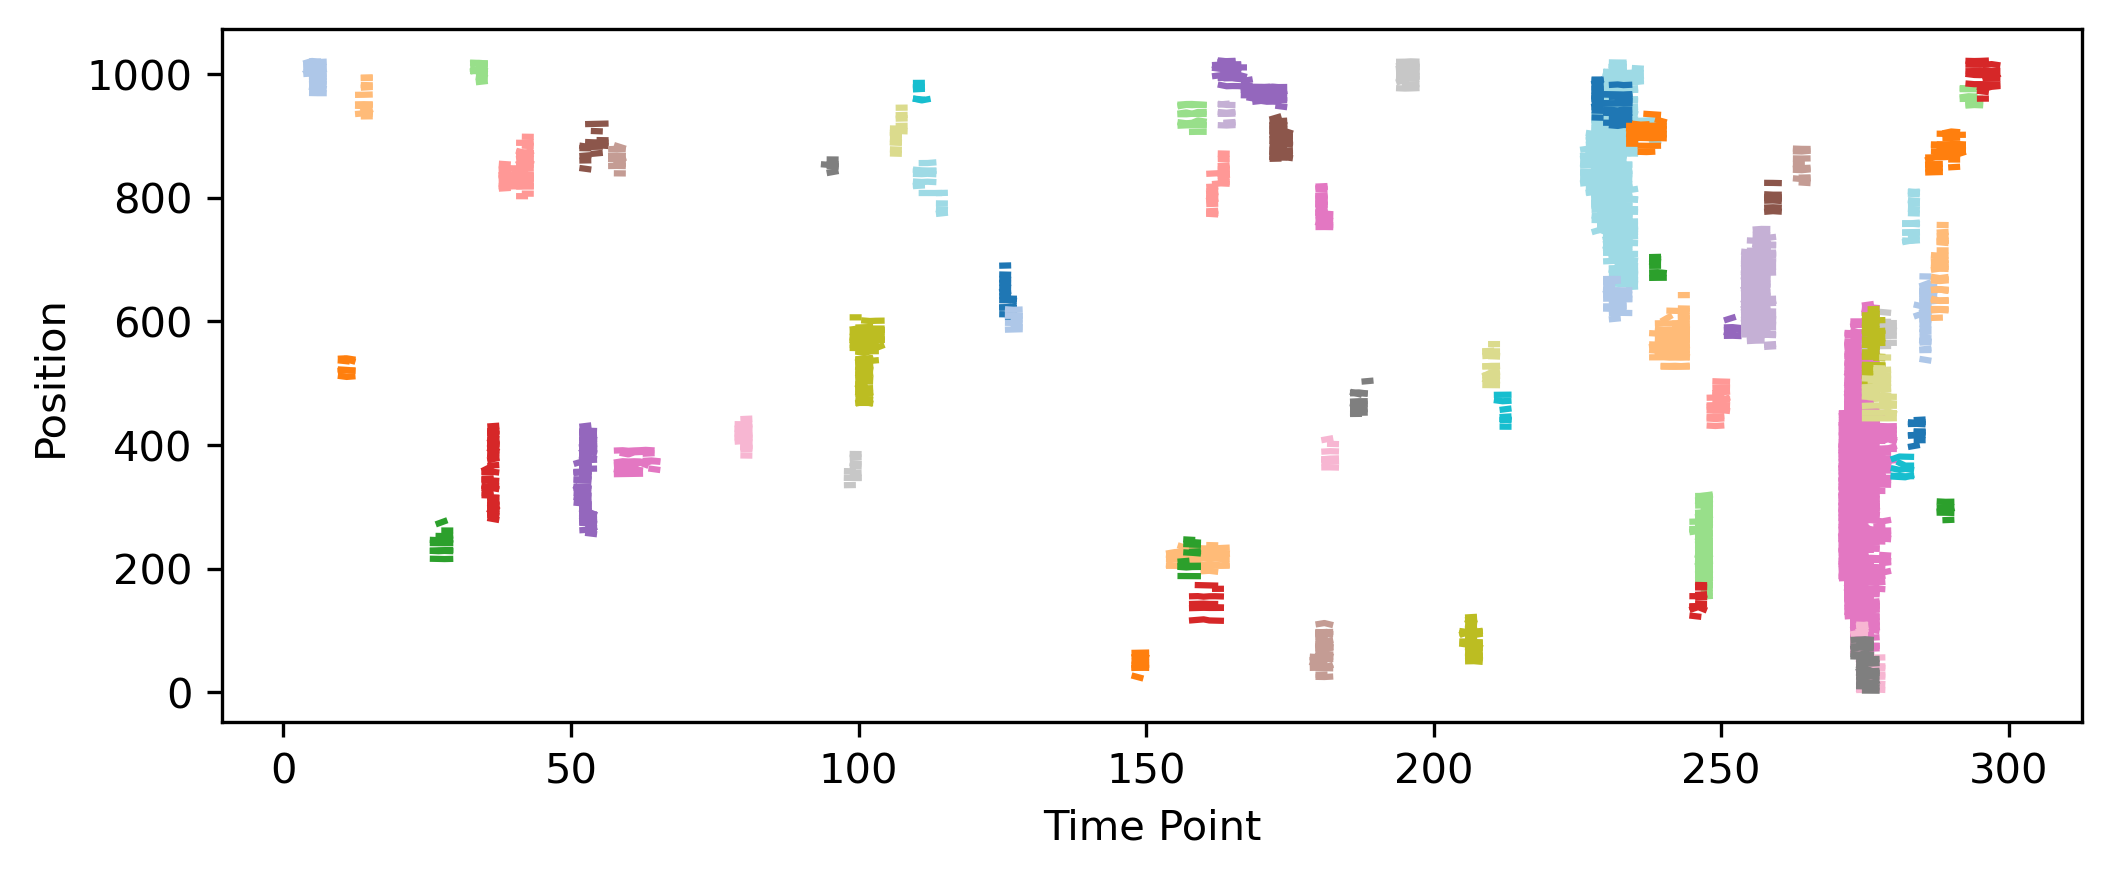

In [34]:
fig = NoodlePlot(arcos_output, 'collid', 'track_id_factorized', 'frame', 'centroid_0', 'centroid_1').plot('centroid_0')

#change figure size
plt.gcf().set_size_inches(8,3)
plt.gcf().set_dpi(300)

If you want to export a movie, you can use the [`napari-timestamper`](https://github.com/bgraedel/napari-timestamper) plugin. This works from the GUI or with the following code:

In [ ]:
import napari_timestamper

stack = napari_timestamper.render_as_rgb(viewer, axis=0)
napari_timestamper.save_image_stack(stack, directory= "../images/calcium_waves_workflow/",name="arcos_output", output_type="mp4")

## Additional tips: Workflow as code instead of using the GUI
Alternatively, the whole workflow can be run as code. To convert `napari-assistant` workflows to code snippets, click `Generate code ...`, then copy-paste to the jupyter notebook. To use the Convpaint API, refer to the tutorial in this documentation.

In [ ]:
from tqdm import tqdm as tqdm
import pyclesperanto_prototype as cle

segmented = viewer.layers['segmented'].data
nb_frames = segmented.shape[0]

edges = []
for frame in tqdm(range(nb_frames)):
    # convert the convpaint semantic segmentation to instance segmentation
    image1_vol = cle.voronoi_otsu_labeling(segmented[frame], None, 2.0, 2.0)

    # expand the labels by 2 pixels
    image1_E = cle.dilate_labels(image1_vol, None, 2.0)

    # reduce the labels to label edges
    image2_rltle = cle.reduce_labels_to_label_edges(image1_E)

    # expand the label edges by 2 pixels
    image3_elwmr = cle.dilate_labels(image2_rltle, None, 2.0)
    edges.append(image3_elwmr)

edges = np.array(edges)
viewer.add_labels(edges)